# Run the routine
First import the main library and run `compute_inventory`

In [1]:
from main import process_file

filename = "data/exposure_conditions_divertor/WEST/West-LSN-P3.58e+21-IP2.5MW.csv"
res = process_file(filename)

The result (`res`) is an object containing several attributes that are:
- `arc_length`: arc_length along the divertor (in m)
- `temperature`: surface temperature profile (in K) along the divertor
- `concentration`: surface mobile concentration profile (in H/m3) along the divertor
- `inventory`: inventory profile (in H per monoblock) along the divertor (divide by the monoblock thickness to get H/m)
- `sigma_inv`: inventory standard deviation along the divertor
- `interp_inv`: scipy.interp2d object. Usage:
    ```python
    T = 350
    c = 1e21
    inventory = res.interp_inv(T, c)
    ```
- `interp_sig`: similar to `interp_inv` but for inventory standard deviation.


# Plot the temperature profile

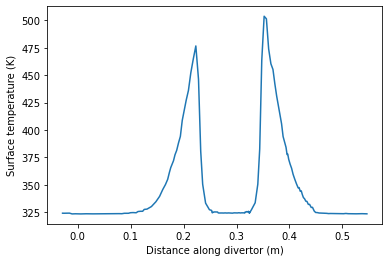

In [2]:
import matplotlib.pyplot as plt
arc_length_div = res.arc_length
T = res.temperature
plt.plot(arc_length_div, T)
xlabel = "Distance along divertor (m)"
plt.xlabel(xlabel)
plt.ylabel("Surface temperature (K)")
plt.show()

# Plot the surface concentration profile

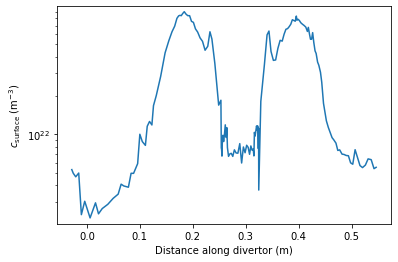

In [3]:
c_max = res.concentration
plt.yscale("log")
plt.ylim(min(c_max)*0.9, max(c_max)*1.1)

plt.plot(arc_length_div, c_max)

plt.xlabel(xlabel)
plt.ylabel("$c_\mathrm{surface}$ (m$^{-3}$)")
plt.show()

# Plot the inventory profile along the divertor

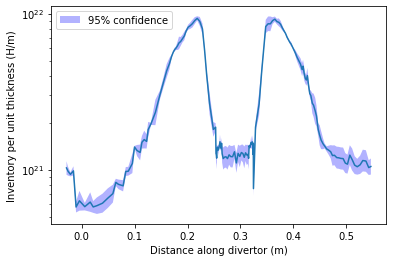

In [4]:
import numpy as np

e = 12e-3  # monoblock thickness (m)
inventories = res.inventory  # inventory in H/m
sigmas = res.sigma_inv

plt.plot(arc_length_div, inventories)

plt.fill_between(
    arc_length_div, 10**(2*sigmas + np.log10(inventories)), 10**(-2*sigmas + np.log10(inventories)),
    facecolor='blue', alpha=0.3, label=r"95% confidence")
plt.legend()
plt.xlabel(xlabel)
plt.yscale("log")
plt.ylabel("Inventory per unit thickness (H/m)")
plt.show()

# Example for several cases

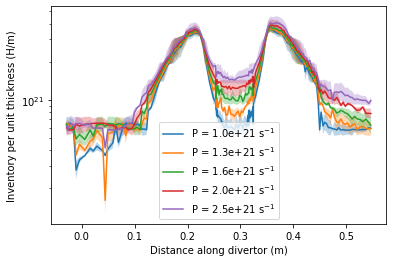

In [5]:
from main import process_file

# puffing rates
Ps = [
    1.0e21,
    1.3e21,
    1.6e21,
    2.0e21,
    2.5e21,
]

for P in Ps:
    filename = "data/exposure_conditions_divertor/WEST/West-LSN-P{:.1e}-IP0.449MW.csv".format(P)
    res = process_file(filename)
    inventories = res.inventory  # inventory in H/m
    sigmas = res.sigma_inv
    line, = plt.plot(res.arc_length, inventories, label="P = {:.1e}".format(P) + " s$^{-1}$")

    plt.fill_between(
        res.arc_length, 10**(2*sigmas + np.log10(inventories)), 10**(-2*sigmas + np.log10(inventories)),
        facecolor=line.get_color(), alpha=0.3)

plt.legend()
plt.xlabel(xlabel)
plt.yscale("log")
plt.ylabel("Inventory per unit thickness (H/m)")
plt.show()

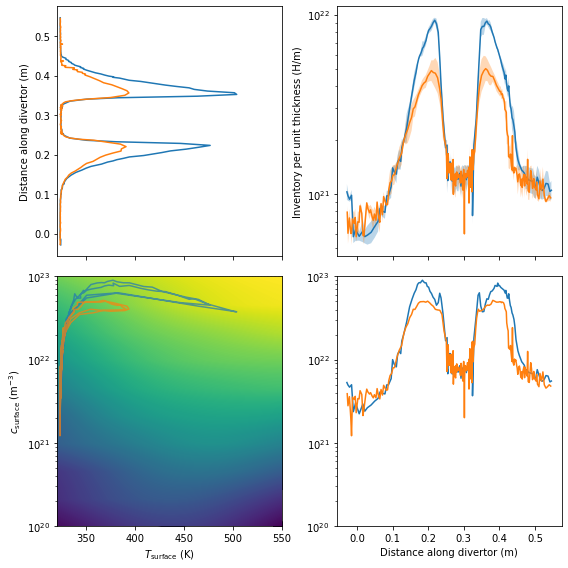

In [6]:
from main import plot_Tc_map_with_subplots

filenames = [
    "data/exposure_conditions_divertor/WEST/West-LSN-P3.58e+21-IP2.5MW.csv",
    "data/exposure_conditions_divertor/WEST/WPN54696-1.5MW-FESTIM_inputs.csv"
]
my_plot = plot_Tc_map_with_subplots(filenames=filenames, T_bounds=[320, 550])
for c in my_plot.CS.collections:  # for avoiding white lines in pdf
        c.set_edgecolor("face")
plt.savefig("2D_map_with_subplots.svg")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


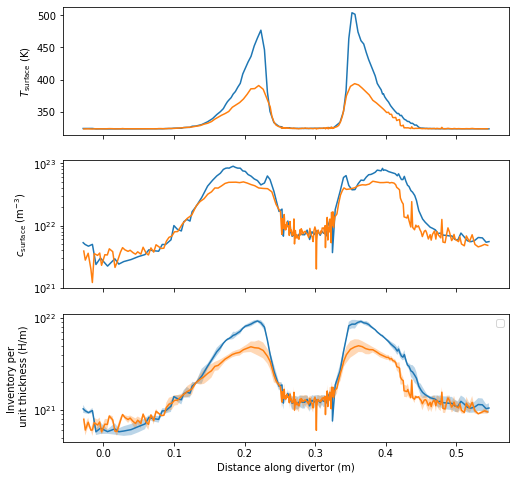

In [7]:
from main import plot_T_c_inv_along_divertor

my_plot = plot_T_c_inv_along_divertor(filenames)
plt.savefig("along_divertor.svg")
my_plot.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


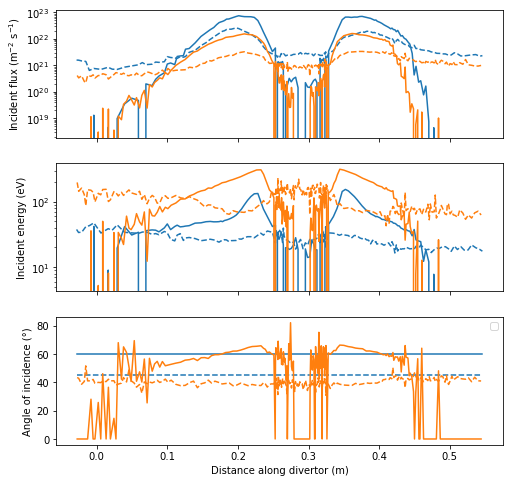

In [8]:
from main import plot_particle_exposure_along_divertor

my_plot = plot_particle_exposure_along_divertor(filenames)
my_plot.show()

No handles with labels found to put in legend.


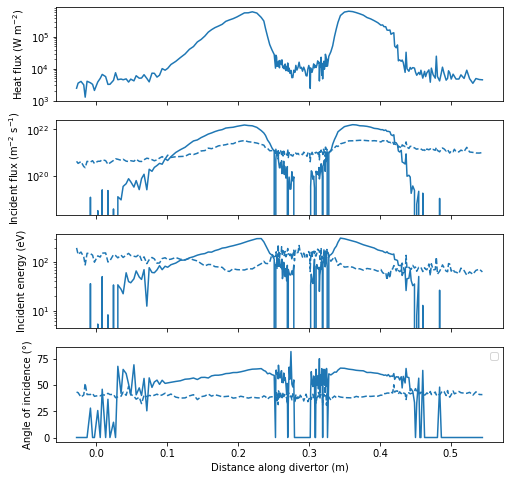

In [9]:
from main import plot_along_divertor
quantities = [
    "heat_flux",
    "ion_flux", "atom_flux",
    "ion_energy", "atom_energy",
    "ion_angle", "atom_angle"
]
my_plot = plot_along_divertor(filenames=[filenames[1]], quantities=quantities)